In [9]:
import glob
import pandas as pd
df1 = pd.DataFrame()
fs = glob.glob("train/cat.*.jpg")
df1["path"] = fs
df1["target"] = 0
df2 = pd.DataFrame()
fs = glob.glob("train/dog.*.jpg")
df2["path"] = fs
df2["target"] = 1
df = pd.concat([df1, df2], axis=0, ignore_index=True)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df["path"], 
                                                    df["target"], 
                                                    test_size=0.2)

In [13]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [56]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.layers import BatchNormalization
# trainable一定要在compile前設置
for l in vgg.layers:
    l.trainable = False
x = BatchNormalization()(vgg.output)
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [57]:
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [36]:
# 請在fit之前 把所有東西轉換成numpy array
import numpy as np
from keras.utils.np_utils import to_categorical
x_train_np = np.array(x_train)
x_test_np = np.array(x_test)
y_train_np = np.array(y_train)
y_train_cat = to_categorical(y_train_np)
y_test_np = np.array(y_test)
y_test_cat = to_categorical(y_test_np)

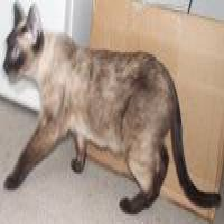

In [38]:
# Pillow(PIL)
from keras.preprocessing.image import load_img
load_img(x_train_np[0], target_size=(224, 224))

In [59]:
# 在預處理圖片 一定用人家的預處理方式
# preprocess_input: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
from keras.applications.vgg16 import preprocess_input
batch = 20
for i in range(5):
    idx = np.random.randint(0, x_train.shape[0], batch)
    ps = x_train_np[idx]
    ts = y_train_cat[idx]
    
    test_idx = np.random.randint(0, x_test.shape[0], 100)
    test_ps = x_test_np[test_idx]
    test_ts = y_test_cat[test_idx]
    
    img_list = []
    for p in ps:
        img = load_img(p, target_size=(224, 224))
        img_pre = preprocess_input(np.array(img))
        img_list.append(img_pre)

    test_img_list = []    
    for test_p in test_ps:
        test_img = load_img(test_p, target_size=(224, 224))
        test_img_pre = preprocess_input(np.array(test_img))
        test_img_list.append(test_img_pre)
        
    img_list_np = np.array(img_list)
    test_img_list_np = np.array(test_img_list)

    
    result = cnn.train_on_batch(img_list_np, ts)
    print("times:", i)
    print("[Train]:", result)
    val_result = cnn.evaluate(test_img_list_np, test_ts)
    print("[Validation]:", val_result)

times: 0
[Train]: [2.0093594, 0.85]
100/100 [==============================] - 21s 213ms/step
[Validation]: [2.7743785858154295, 0.79]
times: 1
[Train]: [0.6607391, 0.9]
100/100 [==============================] - 21s 212ms/step
[Validation]: [0.9310385131835938, 0.92]
times: 2
[Train]: [3.3796885e-06, 1.0]
100/100 [==============================] - 21s 212ms/step
[Validation]: [1.2052336931228638, 0.89]
times: 3
[Train]: [0.7566649, 0.95]
100/100 [==============================] - 21s 212ms/step
[Validation]: [0.7547708654403686, 0.9]
times: 4
[Train]: [0.82957613, 0.85]
100/100 [==============================] - 21s 214ms/step
[Validation]: [0.8987065863609405, 0.86]


In [61]:
# 預測: Model沒有predict_classes
proba = cnn.predict(test_img_list_np)
proba

array([[3.20958970e-05, 9.99967933e-01],
       [1.00000000e+00, 1.52181370e-15],
       [1.00000000e+00, 6.47166917e-14],
       [9.99992728e-01, 7.29133626e-06],
       [1.00000000e+00, 7.24110269e-17],
       [1.48648223e-29, 1.00000000e+00],
       [3.58473867e-34, 1.00000000e+00],
       [8.49648379e-04, 9.99150395e-01],
       [1.00000000e+00, 8.01611974e-24],
       [1.71540663e-07, 9.99999881e-01],
       [1.00000000e+00, 1.77351052e-28],
       [1.00000000e+00, 1.64829522e-13],
       [1.00000000e+00, 2.04609968e-10],
       [1.00000000e+00, 1.08012574e-27],
       [3.53150577e-34, 1.00000000e+00],
       [2.97625802e-13, 1.00000000e+00],
       [1.00000000e+00, 1.44275098e-20],
       [1.00000000e+00, 6.57328824e-31],
       [5.61134385e-12, 1.00000000e+00],
       [2.85821591e-15, 1.00000000e+00],
       [8.00481997e-03, 9.91995215e-01],
       [1.00000000e+00, 1.68107611e-11],
       [9.99986410e-01, 1.36267445e-05],
       [3.70450914e-02, 9.62954879e-01],
       [9.801808

In [63]:
proba.argmax(axis=1)

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int64)

In [65]:
# 把原圖拿出
test_img_list_ori = []    
for test_p in test_ps:
    test_img = load_img(test_p, target_size=(224, 224))
    test_img_list_ori.append(np.array(test_img))
test_img_list_ori = np.array(test_img_list_ori)

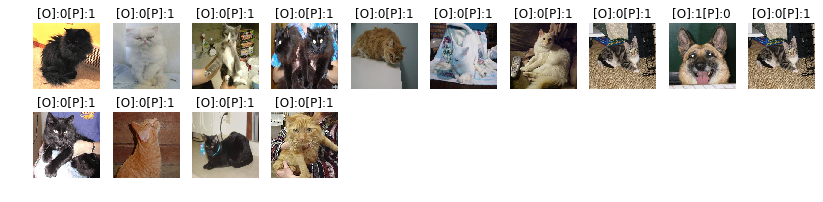

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pre = proba.argmax(axis=1)
# 找出不一樣的預測的index
false_idx = np.nonzero(y_test_np[test_idx] != pre)[0]
# 把所有不一樣的圖片拿出來
false_img = test_img_list_ori[false_idx]
false_ori_label = y_test_np[test_idx][false_idx]
false_pre_label = pre[false_idx]
plt.figure(figsize=(14, 3))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    msg = "[O]:" + str(false_ori_label[i]) + "[P]:" + str(false_pre_label[i])
    plt.title(msg)
    plt.axis("off")
    plt.imshow(img)